# Synergies between SKA and SPHEREx

In [1]:
#packages needed
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from configobj import ConfigObj
from scipy.interpolate import splrep, splev
import scipy as sp
import os

## Intro

We will use IM of 2 lines:
* HI: $\lambda=21$cm
* H$\alpha$: $\lambda=656.3$nm

We will use two surveys:
* SKA1 for HI
* SPHEREx for H$\alpha$

## Specs of each survey

### SKA1 in single dish mode

* Full sky
* Noise: $\mathcal N^{ HI}_{ij}=\frac{S_{\rm area}}{2N_{\rm d} t_{\rm tot}}\int {\rm d} \nu\, T^2_{\rm sys}\left(\nu\right) \bar W_\nu\left(\nu,\nu_i\right) \bar W_\nu( \nu,\nu_j)$ with $T_{\rm sys}=25+60(300\,{\rm MHz}/\nu)^{2.55}\,\rm K$. $\bar{\cal{W}}$ mean the windows are normalized.
* 196 dishes
* $N_d t_{\rm tot}=2\times10^6\,\rm hr$
* High frequency resolution
* Redshift range: z=0-3

### SPHEREx
* full sky but only 7000 $\deg^2$ usable
* Noise: $C_\ell^{\rm noise}=\sigma^2 (\nu I_\nu) \times \Omega_{\rm pixel}$
* $\sigma (\delta\nu I_\nu) \simeq 1 \times 10^{−17}$ erg/s/cm$^2$
* Angular Resolution: $\Omega_{\rm pixel}=6.2"\times6.2"=9.03\times 10^{-10}$Sr
* Frequency resolution: $\lambda/\Delta\lambda= 41.5$ for $0.75<\lambda<4.1\mu$m
* Redshift range: z=0.1-5

## Spect for Multitracer

* Bins/Redshift Res: $\delta z=0.2$, start at $z=0.2$. Reason is numerical lets start with 14 bins and see
* Sky coverage: Study between $7000-30000\deg^2$
* Angular pixel: In the case we have two intensity maps the pixel has to be the same for both. There is no gain of having one with an higher res than the other. Note that repixelizing SPHEREx, i.e., reducing the angular pixel does not change the noise power spectrum. And similarly to the radio. So we can use the pixel from the experiments consistentely. Changing the resolution does not affect the noise power spectrum, only the max available ell. 

In [2]:
#Binning
z=np.arange(0.2,3,0.2)
sigma_z=0.1
#top hat window with good smoothing
smooth=0.01

#Ha
ha_details='../Line IM/Python/ha_details.txt'

z_Ha=np.loadtxt(ha_details)[:,0]
b_Ha_raw=np.loadtxt(ha_details)[:,2]
nuI_Ha_raw=np.loadtxt(ha_details)[:,1]
c=2.998e8
nu_ha=c/(656.3*1e-9*(1+z_Ha))
I_Ha_raw=nuI_Ha_raw/nu_ha

#HI
hi_details='../Multitracer/python/z_OHI_bias_Tmk.txt'
z_hi=np.loadtxt(hi_details)[:,0]
b_hi_raw=np.loadtxt(hi_details)[:,2]
T_hi_raw=np.loadtxt(hi_details)[:,3]

def from_raw_to_surv(z_raw,q_raw,new_z):
    rep=splrep(z_raw,q_raw)
    return splev(new_z,rep)
    
bHa=np.around(from_raw_to_surv(z_Ha,b_Ha_raw,z),3)
#in erg/s/cm^2/Hz/Sr
IHa=from_raw_to_surv(z_Ha,I_Ha_raw,z)
bHI=np.around(from_raw_to_surv(z_hi,b_hi_raw,z),3)
#in mK
THI=from_raw_to_surv(z_hi,T_hi_raw,z)

s_IM=0.4

## Numbers
nT=2
nw=len(z)


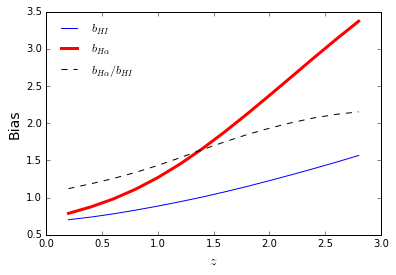

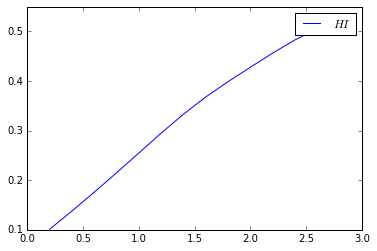

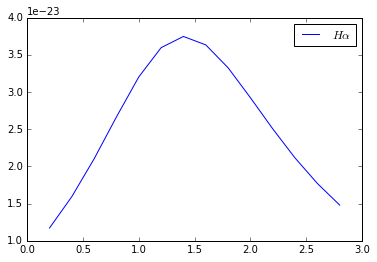

In [30]:
plt.figure(figsize=(6,4))
plt.plot(z,bHI,'b-',label=r'$b_{HI}$')
plt.plot(z,bHa,'r-',lw=3,label=r'$b_{H\alpha}$')
plt.plot(z,bHa/bHI,'k--',label=r'$b_{H\alpha}/b_{HI}$')
plt.xlabel(r'$z$',fontsize=14)
plt.ylabel(r'Bias',fontsize=14)
plt.legend(loc=2,fontsize=12,frameon=False)
plt.savefig('bias_HI_Halpha.pdf')
plt.show()
plt.plot(z,THI,label=r'$HI$')
plt.legend()
plt.show()
plt.plot(z,IHa,label=r'$H\alpha$')
plt.legend()
plt.show()

In [4]:
#Write ini file
cs_folder='/Users/Ze/Documents/Research/CAMBs/cs_ze/'
file_isw_MT='isw_MT_hi_ha.ini'

os.system('cp '+cs_folder+'template.ini '+file_isw_MT)

isw = ConfigObj(file_isw_MT)

isw['output_root']= 'ISW/isw_mt_HI_Ha_dz02_z02_30'
isw['l_max_scalar']= str(600)
isw['accuracy_boost']= str(2)
isw['l_accuracy_boost']= str(2)
isw['l_sample_boost']= str(2)

isw['counts_density']='T' 
isw['counts_redshift']= 'T'
isw['DoRedshiftLensing']='F'
isw['counts_radial']= 'F'
isw['counts_timedelay']= 'F' 
isw['counts_ISW']= 'T'
isw['counts_velocity']= 'T'
isw['counts_potential']= 'T' 
isw['counts_evolve']= 'T'

isw['num_redshiftwindows']=str(nw*nT)
for i in range(nw):
    #first HI Im
    isw['redshift('+str(i+1)+')']= str(z[i])
    isw['redshift_sigma('+str(i+1)+')']= str(sigma_z)
    isw['redshift_kind('+str(i+1)+')']= 'counts'
    isw['redshift_wintype('+str(i+1)+')']= 'smooth_tophat'
    isw['redshift_smooth('+str(i+1)+')']= str(smooth)
    isw['redshift_bias('+str(i+1)+')']= str(bHI[i])
    isw['redshift_dlog10Ndm('+str(i+1)+')']= str(0.4)
    isw['redshift_dNdz('+str(i+1)+')']= 'hiim'

for i in range(nw):
    #second Halpha IM
    isw['redshift('+str(nw+i+1)+')']= str(z[i])
    isw['redshift_sigma('+str(nw+i+1)+')']= str(sigma_z)
    isw['redshift_kind('+str(nw+i+1)+')']= 'counts'
    isw['redshift_wintype('+str(nw+i+1)+')']= 'smooth_tophat'
    isw['redshift_smooth('+str(nw+i+1)+')']= str(smooth)
    isw['redshift_bias('+str(nw+i+1)+')']= str(bHa[i])
    isw['redshift_dlog10Ndm('+str(nw+i+1)+')']= str(0.4)
    isw['redshift_dNdz('+str(nw+i+1)+')']= 'halpha'
    
isw.write()

## Noise of each survey

### H$\alpha$ with Spherex

In [5]:
pix_spherex=9.03e-10 #Sr
#flux sensitivity
sign_dnuI_spherex=1e-17 #erg/s/cm^2
#per Hz
dnu_spherex=nu_ha/41.5
sign_I_spherex_raw=sign_dnuI_spherex/dnu_spherex ##erg/s/cm^2/Hz
#consider the noise integrated over each bin
Delta_nu_bin_halpha=1e9*c/(656.3)*(1/(1+z-sigma_z)-1/(1+z+sigma_z))
sign_I_spherex=from_raw_to_surv(z_Ha,sign_I_spherex_raw,z)/pix_spherex #erg/s/cm^2/Hz/Sr
#for the survey
sign_I_halpha_bin=sign_I_spherex*Delta_nu_bin_halpha #erg/s/cm^2/Sr
#the noise C_\ell
cl_noise_spherex=sign_I_halpha_bin**2*pix_spherex #erg^2/s^2/cm^4/ Sr
print(cl_noise_spherex)

[  5.37228262e-24   3.93237823e-24   3.00350278e-24   2.36923642e-24
   1.91682575e-24   1.58277629e-24   1.32909256e-24   1.13189876e-24
   9.75575697e-25   8.49555118e-25   7.46478190e-25   6.61092606e-25
   5.89567994e-25   5.29057610e-25]


### HI with SKA1

In [6]:
Delta_nu_bin_hi=1420.4*1e6*(1/(1+z-sigma_z)-1/(1+z+sigma_z))
nu_hi=1420.4/(1+z)#Mhz
T2_sys=((20 + 60*(300/nu_hi)**2.55)*1e3)**2 #mK^2
Ndttot = 2e6*3600 #s
N_IM_no_sky=2.0*np.pi*T2_sys/(Ndttot*Delta_nu_bin_hi)
#the full noise depends on the amount of observed sky
#2.0*np.pi*fsky*T2_sys/(Ndttot*Delta_nu_bin_hi)

## Normalizations

In [7]:
## Normalization
I_Ha_bin=IHa*Delta_nu_bin_halpha
print(I_Ha_bin)
Norm=np.ones((nT*nw,nT*nw))
Norm[0:nw,0:nw]=np.array([THI]).T*THI#*1e4
Norm[0:nw,nw:]=np.array([THI]).T*I_Ha_bin#*1e11*1e2
Norm[nw:,0:nw]=Norm[0:nw,nw:].T
Norm[nw:,nw:]=np.array([I_Ha_bin]).T*I_Ha_bin#*1e22

[  7.48569998e-10   7.46884821e-10   7.53425423e-10   7.54031257e-10
   7.33333333e-10   6.80169166e-10   5.95279061e-10   4.91768699e-10
   3.88073795e-10   2.97104051e-10   2.23720422e-10   1.67168393e-10
   1.24943292e-10   9.37264521e-11]


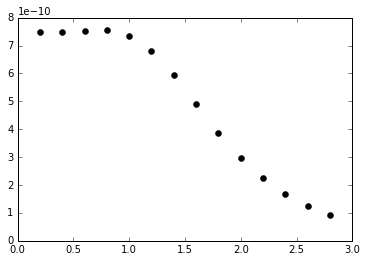

In [8]:
plt.plot(z,I_Ha_bin,'ko')

## Which parameters to put in the fisher matrix?

The natural ones would be what we want to measure or diferentiate
* $f_{\rm NL}$
* $\epsilon_{\rm GR}$
* $\epsilon_{\rm ISW}$

The others would be the normal cosmological parameters $\vartheta={\ln H_0,\ln A_s,\ln n_s,\ln \Omega_{CDM},\ln \Omega_{b},w}$. The ISW will be sensitive to *w* so we expect an high degeneracy with $\epsilon_{\rm ISW}$. I will not marginalize over the biases now, although I can.

The fiducial are $H_0=67,74$ km/s/Mpc, $A_s=2.142 \times 10^{−9}$, $n_s=0.967$, $\Omega_{CDM}=0.26$,  $\Omega_{b}=0.05$,$w=-1$, $f_{\rm NL}=0$, $\epsilon_{\rm GR}=1$ and $\epsilon_{\rm ISW}=1$.


## Load the angular power spectra

In [9]:
folder='data/'
root='isw_mt_hi_ha_dz02_z02_30_'
parametername=['Ocdm','ns','Ob','w','H0','fnl','eISW','edoppler','eSW']
for i in range(0,nw):
    parametername=parametername+['bhi'+str(i+1)]
for i in range(0,nw):
    parametername=parametername+['bha'+str(i+1)]
print(parametername)

fid_norm=[0.26,0.9667,0.05,1,67.74,1.3,1,1,1]+[1]*nT*nw
#print(len(fid_norm))
#print(len(parametername))
pars=['As']+parametername

['Ocdm', 'ns', 'Ob', 'w', 'H0', 'fnl', 'eISW', 'edoppler', 'eSW', 'bhi1', 'bhi2', 'bhi3', 'bhi4', 'bhi5', 'bhi6', 'bhi7', 'bhi8', 'bhi9', 'bhi10', 'bhi11', 'bhi12', 'bhi13', 'bhi14', 'bha1', 'bha2', 'bha3', 'bha4', 'bha5', 'bha6', 'bha7', 'bha8', 'bha9', 'bha10', 'bha11', 'bha12', 'bha13', 'bha14']


In [10]:
def column(tr1,tr2,b1,b2,Nb):
    return (tr1 - 1)* (2* Nb)* Nb + (b1 - 1)* (2 *Nb) + (tr2 - 1)* Nb + b2 - 1

In [11]:
var_fisher={}
### Cut the first bin

var_fisher['l']=np.arange(2,501)
var_fisher['fid']=np.loadtxt(folder+root+'fid_Cl.dat')[:,1:]#use_cols]
#indeces=abs(var_fisher['fid'])<1e-16
#var_fisher['fid'][indeces]=0.0
var_fisher['As']=var_fisher['fid']
for i in range(len(parametername)):
    #print(parametername[i])
    var_fisher[parametername[i]]=np.loadtxt(folder+root+parametername[i]+'_dCl.dat')[:,1:]*fid_norm[i]
        
    #indeces=abs(var_fisher[parametername[i]])<1e-16
    #var_fisher[parametername[i]][indeces]=0.0


In [12]:
klass = type('Cls', (object,), var_fisher)
Cls_ISW_HI_Halpha = klass()

## Define and Compute the Fisher Matrix

In [13]:
def H(z):
    return 67.74*(0.31*(1+z)**3+0.69)**0.5
#in Km/s/Mpc

def chi(z):
    chiev=np.zeros(len(z))
    for i in range(len(z)):
        zinte=np.arange(0,z[i],0.001)
        chiev[i]=np.trapz(c*1e-3/H(zinte),zinte)
    return chiev

ell_bin_max=np.append(np.around(0.2*0.67*(1+z)**(2/(2+0.967))*chi(z),0),
                   np.around(0.2*0.67*(1+z)**(2/(2+0.967))*chi(z),0))



In [14]:
def fisher_fsky_l(Cls_mtr,fsky,lmin,lmax,norm,N_IM_no_sky,cl_noise_spherex,ell_bin_max,pars,windows,
                  tracers,noise_level=1,use_cut=False,cut=[]):
    bins=windows*tracers
    cut_or=np.arange(0,bins)
    npars=len(pars)
    fisher=np.zeros((npars,npars))
    if lmin<2:
        lmin=2
    l_range=np.arange(lmin-2,lmax-1,1)
    Noise=np.zeros((windows*tracers,windows*tracers))    
    Noise[0:windows,0:windows]=np.diag(N_IM_no_sky*fsky)#*1e3
    Noise[windows:,windows:]=np.diag(cl_noise_spherex)#*1e22
    
    
    for k in l_range:
        if use_cut==True:
            cut=cut
        else:
            cut_index=(ell_bin_max>k)
            cut=cut_or[cut_index]
        #print(cut)
        temp=np.zeros((npars,npars))
        #eigvals, Umatrix=sp.linalg.eigh((Cls_mtr.fid[k,:].reshape(bins,bins)*norm+Noise*noise_level)[cut,:][:,cut])
        #Triag, Z=sp.linalg.schur((Cls_mtr.fid[k,:].reshape(bins,bins)*norm+Noise*noise_level)[cut,:][:,cut])
        invGamma=sp.linalg.inv((Cls_mtr.fid[k,:].reshape(bins,bins)*norm+Noise*noise_level)[cut,:][:,cut])
        #invGamma=np.dot(np.dot(Umatrix,np.diag(1/eigvals)),sp.linalg.inv(Umatrix))
        #invGamma=np.dot(Z,np.dot(sp.linalg.inv(Triag),Z.T))
        #all methods are equivalent
        for i in range(npars):
            dcl1=((getattr(Cls_mtr, pars[i])[k,:].reshape(bins,bins)*norm))[cut,:][:,cut]
            for j in range(npars):
                if j<i:
                    next                  
                dcl2=((getattr(Cls_mtr, pars[j])[k,:].reshape(bins,bins)*norm))[cut,:][:,cut]
                #print(dcl2)
                temp[i,j]=np.trace(dcl1.dot(invGamma.dot(dcl2.dot(invGamma))))
                temp[j,i]=temp[i,j]
        
        fisher=fisher+(2*Cls_mtr.l[k]+1)*temp
    
    fisher=fisher*fsky/2.0
    return fisher


In [15]:
# Sky overlaps
f_sky=[0.25,0.5,0.75]

## Single tracer

### SKA only


In [16]:
for fsky in f_sky:
    print('Sky Area:', fsky)
    lmin_obs=int(np.pi/np.sqrt(4*np.pi*fsky))+1
    fisher_IM_HI_Ha=fisher_fsky_l(Cls_ISW_HI_Halpha,fsky,lmin_obs,300,Norm,N_IM_no_sky,cl_noise_spherex,
                              ell_bin_max,pars[:-14],14,2,use_cut=True,cut=np.arange(0,14))
    sigma2_IM_HI_Ha=np.linalg.inv(fisher_IM_HI_Ha)
    print('sigma :','Marginal','Conditional')
    for i in range(len(pars[:-14])):
        sig_epsISW_IM_HI_Ha=np.sqrt(sigma2_IM_HI_Ha[i,i])
        print(pars[i]+':',sig_epsISW_IM_HI_Ha,',',np.sqrt(1/fisher_IM_HI_Ha[i,i]))

Sky Area: 0.25
sigma : Marginal Conditional
As: 0.270329599112 , 0.0026224007377
Ocdm: 0.155482737284 , 0.00253015039383
ns: 0.0862861240347 , 0.00389396609122
Ob: 0.252064149274 , 0.00524980294265
w: 0.153595615107 , 0.0146539911765
H0: 0.139306734445 , 0.00139945559939
fnl: 7.51664215684 , 3.77096599733
eISW: 18.5118308392 , 14.1405094011
edoppler: 10.3410118749 , 4.41473345767
eSW: 4.58505352176 , 1.51633847688
bhi1: 0.0384845294966 , 0.00201811734136
bhi2: 0.0380946921292 , 0.00206570664951
bhi3: 0.0386125999908 , 0.00213497931226
bhi4: 0.0396064809141 , 0.00221506832259
bhi5: 0.0409366343841 , 0.00230222560279
bhi6: 0.0422706745674 , 0.00239222180453
bhi7: 0.0436551255676 , 0.0024831918971
bhi8: 0.0451243798665 , 0.00257841176629
bhi9: 0.0466002442268 , 0.00267620259132
bhi10: 0.0480520207903 , 0.00277643897393
bhi11: 0.0494059864788 , 0.00287611362873
bhi12: 0.050688888043 , 0.00297728642642
bhi13: 0.0519075689631 , 0.0030824498832
bhi14: 0.0530809524856 , 0.00319456179982
Sky Ar

## SPHEREx only

In [17]:
par_Ha=pars[:-28]+pars[-14:]
for fsky in f_sky:
    print('Sky Area:', fsky)
    lmin_obs=int(np.pi/np.sqrt(4*np.pi*fsky))+1
    fisher_IM_HI_Ha=fisher_fsky_l(Cls_ISW_HI_Halpha,fsky,lmin_obs,300,Norm,N_IM_no_sky,cl_noise_spherex,
                              ell_bin_max,par_Ha,14,2,use_cut=True,cut=np.arange(14,28))
    sigma2_IM_HI_Ha=np.linalg.inv(fisher_IM_HI_Ha)
    print('sigma :','Marginal','Conditional')
    for i in range(len(par_Ha)):
        sig_epsISW_IM_HI_Ha=np.sqrt(sigma2_IM_HI_Ha[i,i])
        print(par_Ha[i]+':',sig_epsISW_IM_HI_Ha,',',np.sqrt(1/fisher_IM_HI_Ha[i,i]))

Sky Area: 0.25
sigma : Marginal Conditional
As: 0.919520892514 , 0.00735723070106
Ocdm: 0.360966320333 , 0.00845961034774
ns: 0.263904847218 , 0.010961670143
Ob: 0.671132248944 , 0.0167394133688
w: 0.344820005397 , 0.0392135328781
H0: 0.438918949912 , 0.00434211329215
fnl: 9.42407903541 , 4.19827411583
eISW: 22.4617903361 , 16.1169463492
edoppler: 3.74375585546 , 1.95687049581
eSW: 6.19581386594 , 2.14193650461
bha1: 0.155604287404 , 0.00800345697336
bha2: 0.163051167618 , 0.00771939824889
bha3: 0.172767795418 , 0.00720641048847
bha4: 0.183920048317 , 0.00663248095049
bha5: 0.19570867378 , 0.00625422055839
bha6: 0.207382076832 , 0.00615220649595
bha7: 0.218527610961 , 0.00636148452274
bha8: 0.228919210334 , 0.00695931819194
bha9: 0.238318904397 , 0.00805895031075
bha10: 0.246631543322 , 0.00985102156588
bha11: 0.253838061414 , 0.0126545928574
bha12: 0.260208009872 , 0.0169890837892
bha13: 0.265933068894 , 0.0236452707781
bha14: 0.27145749997 , 0.0338394427245
Sky Area: 0.5
sigma : Marg

## MT SKA SPHEREx

In [18]:
prior=np.zeros((len(pars),len(pars)))
prior[0:6,0:6]=np.diag([1/(0.05)**2]*6)

In [19]:
for fsky in f_sky:
    print('Sky Area:', fsky)
    lmin_obs=int(np.pi/np.sqrt(4*np.pi*fsky))+1
    fisher_IM_HI_Ha=fisher_fsky_l(Cls_ISW_HI_Halpha,fsky,lmin_obs,300,Norm,N_IM_no_sky,cl_noise_spherex,
                              ell_bin_max,pars,14,2)
    sigma2_IM_HI_Ha=np.linalg.inv(fisher_IM_HI_Ha)#+prior)
    print('sigma :','Marginal','Conditional')
    for i in range(len(pars)):
        sig_epsISW_IM_HI_Ha=np.sqrt(sigma2_IM_HI_Ha[i,i])
        print(pars[i]+':',sig_epsISW_IM_HI_Ha,',',np.sqrt(1/fisher_IM_HI_Ha[i,i]))

Sky Area: 0.25
sigma : Marginal Conditional
As: 0.377889509659 , 0.00271970713681
Ocdm: 0.153512969595 , 0.00279501752073
ns: 0.124395316897 , 0.00489323526589
Ob: 0.290289607496 , 0.00568758197776
w: 0.159455896513 , 0.0163060463576
H0: 0.205964992614 , 0.00150610706277
fnl: 3.62927112919 , 2.47853048938
eISW: 13.3499387507 , 11.0851568325
edoppler: 0.483293928226 , 0.475158404589
eSW: 2.03046774237 , 1.33962407558
bhi1: 0.0308976640056 , 0.00360133816821
bhi2: 0.0302933153778 , 0.00206909701964
bhi3: 0.0305127417448 , 0.00192201552516
bhi4: 0.0311133776774 , 0.00194782460699
bhi5: 0.0321518955534 , 0.00197641139049
bhi6: 0.0331406932601 , 0.00201991836064
bhi7: 0.03416649112 , 0.00209265822574
bhi8: 0.0352971927864 , 0.00220541384652
bhi9: 0.0364329142288 , 0.00235042269245
bhi10: 0.0375755274365 , 0.00251236362682
bhi11: 0.0386855128279 , 0.00267449781432
bhi12: 0.0397372108999 , 0.00283019283281
bhi13: 0.0407242954349 , 0.00297867750375
bhi14: 0.0416999300385 , 0.00312322252366
bha

## Effect of varying the noise 

In [20]:
lmin_obs=int(np.pi/np.sqrt(4*np.pi*0.5))+1
noise_per=np.arange(-3,0.1,0.1)
sigmas_05=np.zeros((4,len(noise_per)))
for i in range(len(noise_per)):
    print(noise_per[i])
    fisher_IM_HI_Ha=fisher_fsky_l(Cls_ISW_HI_Halpha,0.5,lmin_obs,300,Norm,N_IM_no_sky,cl_noise_spherex,
                              ell_bin_max,pars,14,2,noise_level=10**noise_per[i])
    sigma2_IM_HI_Ha=np.linalg.inv(fisher_IM_HI_Ha)
    sigmas_05[:,i]=np.sqrt(np.diagonal(sigma2_IM_HI_Ha[6:10,6:10]))

-3.0
-2.9
-2.8
-2.7
-2.6
-2.5
-2.4
-2.3
-2.2
-2.1
-2.0
-1.9
-1.8
-1.7
-1.6
-1.5
-1.4
-1.3
-1.2
-1.1
-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.4
-0.3
-0.2
-0.1
2.6645352591e-15


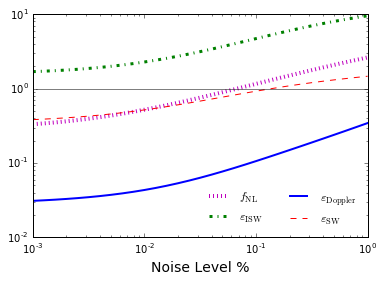

In [21]:
pars_gr=[r'$f_{\rm NL}$',r'$\varepsilon_{\rm ISW}$',r'$\varepsilon_{\rm Doppler}$',r'$\varepsilon_{\rm SW}$']
colors='mgbr'
style=[':','-.','-','--']
size_line=[4,3,2,1]
plt.figure(figsize=(6,4))
for i in range(4):
    plt.plot(10**noise_per,sigmas_05[i,:],color=colors[i],ls=style[i],lw=size_line[i],label=pars_gr[i])
plt.axhline(y=1, xmin=0.01, xmax=1, linewidth=0.5, color = 'k')
plt.xlabel('Noise Level %',fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=4,frameon=False,fontsize=12,ncol=2)
plt.savefig('noise_level_effect_fsky05.pdf')
plt.show()

-3.0
-2.9
-2.8
-2.7
-2.6
-2.5
-2.4
-2.3
-2.2
-2.1
-2.0
-1.9
-1.8
-1.7
-1.6
-1.5
-1.4
-1.3
-1.2
-1.1
-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.4
-0.3
-0.2
-0.1
2.6645352591e-15


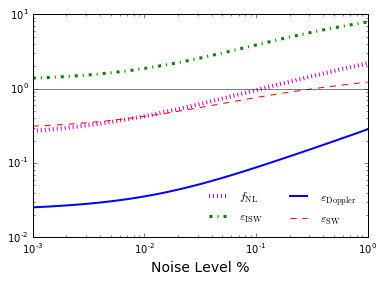

In [22]:
lmin_obs=int(np.pi/np.sqrt(4*np.pi*0.75))+1
noise_per=np.arange(-3,0.1,0.1)
sigmas=np.zeros((4,len(noise_per)))
for i in range(len(noise_per)):
    print(noise_per[i])
    fisher_IM_HI_Ha=fisher_fsky_l(Cls_ISW_HI_Halpha,0.75,lmin_obs,300,Norm,N_IM_no_sky,cl_noise_spherex,
                              ell_bin_max,pars,14,2,noise_level=10**noise_per[i])
    sigma2_IM_HI_Ha=np.linalg.inv(fisher_IM_HI_Ha)
    sigmas[:,i]=np.sqrt(np.diagonal(sigma2_IM_HI_Ha[6:10,6:10]))
    
#pars_gr=[r'$f_{\rm NL}$',r'$\varepsilon_{\rm ISW}$',r'$\varepsilon_{\rm Doppler}$',r'$\varepsilon_{\rm SW}$']
#colors='mgbr'
#style=[':','-.','-','--']
#size_line=[4,3,2,1]
plt.figure(figsize=(6,4))
for i in range(4):
    plt.plot(10**noise_per,sigmas[i,:],color=colors[i],ls=style[i],lw=size_line[i],label=pars_gr[i])
plt.axhline(y=1, xmin=0.01, xmax=1, linewidth=0.5, color = 'k')
plt.xlabel('Noise Level %',fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=4,frameon=False,fontsize=12,ncol=2)
plt.savefig('noise_level_effect_fsky075.pdf')
plt.show()

### Make contour plots

In [23]:
lmin_obs=int(np.pi/np.sqrt(4*np.pi*fsky))+1
fisher_IM_HI_Ha=fisher_fsky_l(Cls_ISW_HI_Halpha,fsky,lmin_obs,300,Norm,N_IM_no_sky,cl_noise_spherex,
                              ell_bin_max,pars,14,2)
sigma2_IM_HI_Ha=np.linalg.inv(fisher_IM_HI_Ha)
sigma2_IM_HI_Ha

array([[  5.28718442e-02,  -1.15465737e-02,   1.65063095e-02, ...,
         -3.62478426e-03,  -3.66434866e-03,  -3.69607337e-03],
       [ -1.15465737e-02,   8.60974050e-03,  -4.39415494e-03, ...,
          8.82897957e-05,   7.02656746e-05,   5.58977853e-05],
       [  1.65063095e-02,  -4.39415494e-03,   5.73634890e-03, ...,
         -5.51944382e-04,  -5.49654124e-04,  -5.47131745e-04],
       ..., 
       [ -3.62478426e-03,   8.82897957e-05,  -5.51944382e-04, ...,
          9.60702217e-04,   9.37680505e-04,   9.53290607e-04],
       [ -3.66434866e-03,   7.02656746e-05,  -5.49654124e-04, ...,
          9.37680505e-04,   1.02001849e-03,   9.72793731e-04],
       [ -3.69607337e-03,   5.58977853e-05,  -5.47131745e-04, ...,
          9.53290607e-04,   9.72793731e-04,   1.08695333e-03]])

In [24]:
fnl_array=np.arange(-6,6,0.05)
eps_array=np.arange(-15,16,0.05)

def confidence(x,y,xfid,yfid,F):
    #sig2=sp.linalg.det(sp.linalg.inv(F))
    pararray=np.array([x,y])
    fidarray=np.array([xfid,yfid])
    test_vec=pararray-fidarray
    #return 1/(2*np.pi*sig2)*np.exp(-(test_vec.dot(F.dot(test_vec.T)))/2)
    return test_vec.dot(F.dot(test_vec.T))

In [25]:
contour_doppler=np.zeros((len(fnl_array),len(eps_array)))
contour_isw=np.zeros((len(fnl_array),len(eps_array)))
contour_pot=np.zeros((len(fnl_array),len(eps_array)))


for i in range(len(fnl_array)):
    for j in range(len(eps_array)):
        contour_isw[i,j]=confidence(fnl_array[i],eps_array[j],0,1,fisher_IM_HI_Ha[[6,7],:][:,[6,7]])
        contour_pot[i,j]=confidence(fnl_array[i],eps_array[j],0,1,fisher_IM_HI_Ha[[6,9],:][:,[6,9]])
        contour_doppler[i,j]=confidence(fnl_array[i],eps_array[j],0,1,fisher_IM_HI_Ha[[6,8],:][:,[6,8]])
        
    

/Users/Ze/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/Ze/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


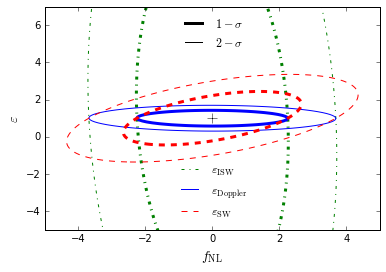

In [31]:
plt.figure()
plt.contour(fnl_array, eps_array,contour_isw.T,colors='g',levels=[2.3,6.17],linewidths=(3,1),linestyles='-.')
plt.contour(fnl_array, eps_array,contour_doppler.T,colors='b',levels=[2.3,6.17],linewidths=(3,1),linestyles='-')
plt.contour(fnl_array, eps_array,contour_pot.T,colors='r',levels=[2.3,6.17],linewidths=(3,1),linestyles='--')
plt.xlabel(r'$f_{\rm NL}$',fontsize=14)
plt.ylabel(r'$\varepsilon$',fontsize=14)
plt.plot(0,1,'k+',ms=10)
cores='gbr'
import matplotlib.lines as mlines
eps_line=[]
style=['-.','-','--']
for i in range(3):
    eps_line.append(mlines.Line2D([], [], color=cores[i],label=pars_gr[i+1],linestyle=style[i]))
    #plt.legend(handles=[eps_line],loc=2)
first_legend=plt.legend(handles=eps_line[:],loc=8,frameon=False,fontsize=12)
plt.gca().add_artist(first_legend)
sig_line=[]
sig_label=[r'$1-\sigma$',r'$2-\sigma$']
for i in range(2):
    sig_line.append(mlines.Line2D([], [], color='k',label=sig_label[i],linewidth=[3,1][i]))
plt.legend(handles=sig_line[:],loc=9,frameon=False,fontsize=12)
plt.ylim([-5,7])
plt.xlim([-5,5])
plt.savefig('onesigma_fnl_eps.pdf')
plt.show()

In [27]:
contour_disw=np.zeros((len(eps_array),len(eps_array)))
contour_dpot=np.zeros((len(eps_array),len(eps_array)))

for i in range(len(eps_array)):
    for j in range(len(eps_array)):
        contour_disw[i,j]=confidence(eps_array[i],eps_array[j],1,1,fisher_IM_HI_Ha[[7,8],:][:,[7,8]])
        contour_dpot[i,j]=confidence(eps_array[i],eps_array[j],1,1,fisher_IM_HI_Ha[[8,9],:][:,[8,9]])

/Users/Ze/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/Ze/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


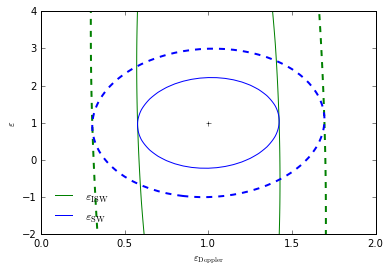

In [28]:
plt.figure()
plt.contour(eps_array, eps_array,contour_disw,levels=[2.3,6.17],colors='g',linewidths=(1,2),linestyles=('-','--'))
plt.contour(eps_array, eps_array,contour_dpot.T,levels=[2.3,6.16],colors='b',linewidths=(1,2),linestyles=('-','--'))

plt.xlabel(pars_gr[2])
plt.ylabel(r'$\varepsilon$')
plt.plot(1,1,marker='+',color='k',ms=5)
cores='gb'
import matplotlib.lines as mlines
eps_line=[]
pars_gr_dop=[pars_gr[1]]+[pars_gr[3]]
for i in range(2):
    eps_line.append(mlines.Line2D([], [], color=cores[i],label=pars_gr_dop[i]))
plt.legend(handles=eps_line[:],loc=3,frameon=False,fontsize=12)
plt.ylim([-2,4])
plt.xlim([-0,2])
plt.savefig('onesigma_dop_eps.pdf')
plt.show()